source: https://github.com/bottama/stochastic-asset-pricing-in-continuous-time/blob/main/geometric-brownian-motion.py

In [2]:
!pip install yfinance

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for frozendict: filename=frozendict-2.4.4-cp39-cp39-macosx_10_9_x86_64.whl size=36224 sha256=5f13358d69a0bb5e91f6ec296e67dde6a69db7846279312612ef6bd8bd5c4867
  Stored in directory: /Users/vitorihaldijiran/Library/Caches/pip/wheels/fa/a3/fa/ee5dd1c7ded39e90b84882fcf272ab9f8801eafb7094a5c214
  Created wheel for peewee: filename=peewee-3.17.6-cp39-cp39-macosx_10_9_x86_64.whl size=254004 sha256=02515bd7a2697f80777b4c7a7acac26d74dd2d298ae0c67b7c4b7e069f3954b8
  Stored in directory: /Users/vitorihaldijiran/Library/Caches/pip/wheels/3e/23/b4/7729b2d48a34ee9d95c11f7f8dfd4ff0571a056e2691118b34
Successfully built frozendict peewee
  Atte

[*********************100%%**********************]  1 of 1 completed
/var/folders/mk/qm568t1n2t11r_13jw7_kn400000gn/T/ipykernel_25914/622998770.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  So = train_set[-1]


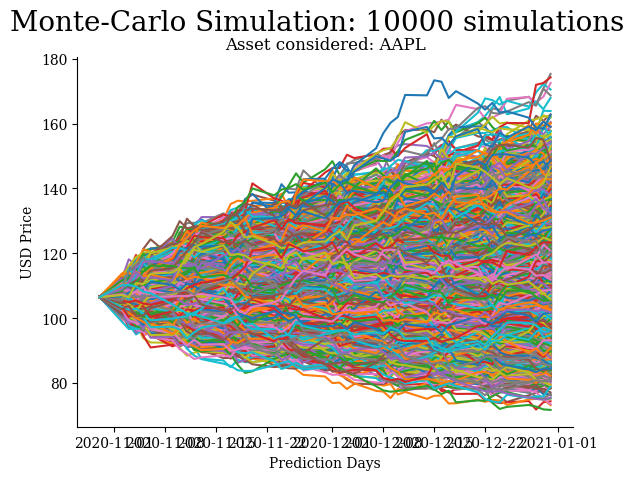

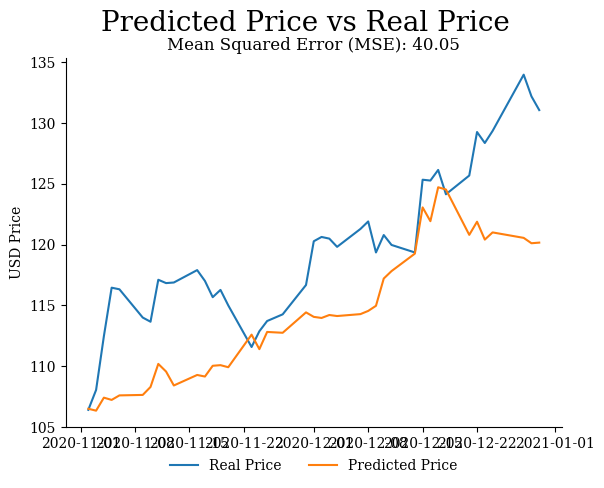

In [3]:
""" Asset Pricing in continuous time with the Geometric Brownian Motion (GBM) and the Monte-Carlo simulation"""

"""
Author: Matteo Bottacini, matteo.bottacini@usi.ch
Last update: March 4, 2021
"""

# import modules
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# main variables
# stock_name    :   ticker symbol from yahoo finance
# start_date    :   start date to download prices
# end_date      :   end date to download prices
# pred_end_date :   date until which you want to predict price
# scen_size     :   different possible scenarios
stock_name = 'AAPL'
start_date = '2010-01-01'
end_date = '2020-10-31'
pred_end_date = '2020-12-31'
scen_size = 10000

# download and prepare data
prices = yf.download(tickers=stock_name, start=start_date, end=pred_end_date)['Adj Close']
train_set = prices.loc[:end_date]
test_set = prices.loc[end_date:pred_end_date]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

# Geometric Brownian Motion (GBM)

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path


# Parameter Assignments
So = train_set[-1]
dt = 1  # day   # User input
n_of_wkdays = pd.date_range(start=pd.to_datetime(end_date,
                                                 format="%Y-%m-%d") + pd.Timedelta('1 days'),
                            end=pd.to_datetime(pred_end_date,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()
T = n_of_wkdays
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}


# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Adj Close'], S_pred],
                        index=['real', 'pred']).T
final_df.index = test_set.index
mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)

# Plotting the simulations
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Monte-Carlo Simulation: ' + str(scen_size) + ' simulations', fontsize=20)
plt.title('Asset considered: {}'.format(stock_name))
plt.ylabel('USD Price')
plt.xlabel('Prediction Days')
for i in range(scen_size):
    plt.plot(pd.date_range(start=train_set.index[-1],
                           end=pred_end_date,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
plt.show()

# Plotting the final prediction against the real price
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Predicted Price vs Real Price', fontsize=20)
plt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
plt.ylabel('USD Price')
plt.plot(final_df)
plt.legend(['Real Price', 'Predicted Price'],
           loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
plt.show()